# Enriching Machine Learning Prediction of House Rent Per Meter Square Using Geo-data  

#### by

### Ifeanyi Innocent Okaro 

In this excercise I will use machine learning algorithm to predict house rent price per square meter for different areas in Hamburg. The aim is to optimize and enhance prediction by adding geodata to the existing data. The data is provided in a csv file. The Geodata will be obtained from https://geoportal-hamburg.de/geo-online/# .
Lets start with exploring the data. Note: There are some uncommon libraries that my be needed in order to run all the codes in this notebook. These can be installed with the commands in the first cell. 

In [1]:
#pip install geopandas
#pip install shapely
#pip install contextily==1.0rc2
#conda install -c conda-forge owslib
#conda install -c conda-forge descartes

In [2]:
import numpy as np
import pandas as pd
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely import wkt

We import the csv data containig our records.

In [3]:
# Reading the data
data1 = pd.read_csv("task_data_final.csv")
print(data1.shape)
data1.head()

(12500, 15)


,living_space,rooms,cold_rent,construction_year,quarter,lambert_poistion_x,lambert_poistion_y,city,postcode,heating_type,number_of_bedrooms,rent_per_square_meter,publish_date,latitude,longitude
0,116.4,4.5,1453.2,1976.0,Farmsen-Berne,7967.0,2625150.0,Hamburg,22159,6,NaN,14.976,2019-05-30 22:00:00,53.597793,10.121997
1,78.0,3.0,819.6,NaN,Wandsbek,5628.0,2623928.0,Hamburg,22047,1,NaN,12.612,2019-01-31 23:00:00,53.586691,10.086159
2,62.4,3.5,504.0,NaN,Wilstorf,-239.0,2608361.0,Hamburg,21079,1,NaN,9.696,2019-01-31 23:00:00,53.444908,9.996353
3,98.4,3.5,1131.6,1982.0,Rahlstedt,9481.0,2628105.0,Hamburg,22145,1,NaN,13.800,2019-04-30 22:00:00,53.624685,10.145269
4,144.0,3.5,2280.0,NaN,Blankenese,-13093.0,2620974.0,Hamburg,22587,5,2.0,18.996,2019-03-28 23:00:00,53.559652,9.799682


Looking at the data, we can see that there are NaN values. We need to treat these values. Lets get an idea of how these NaN are distributed across our data

In [4]:
data1.isna().sum()

living_space                0
rooms                       6
cold_rent                   0
construction_year        2610
quarter                     0
lambert_poistion_x         80
lambert_poistion_y         80
city                        0
postcode                    0
heating_type              913
number_of_bedrooms       7722
rent_per_square_meter       0
publish_date                0
latitude                   80
longitude                  80
dtype: int64

We can see that "number_of_bedrooms" have way too many NaN values. So we drop the column and for the other columns, we drop the rows with NaN.

In [5]:
# dropping NaN
data1 = data1.drop(["number_of_bedrooms"], axis = 1)
data1 = data1.dropna(axis='rows')
print(data1.shape)
data1.head()

(9332, 14)


,living_space,rooms,cold_rent,construction_year,quarter,lambert_poistion_x,lambert_poistion_y,city,postcode,heating_type,rent_per_square_meter,publish_date,latitude,longitude
0,116.4,4.5,1453.200,1976.0,Farmsen-Berne,7967.0,2625150.0,Hamburg,22159,6,14.976,2019-05-30 22:00:00,53.597793,10.121997
3,98.4,3.5,1131.600,1982.0,Rahlstedt,9481.0,2628105.0,Hamburg,22145,1,13.800,2019-04-30 22:00:00,53.624685,10.145269
5,97.8,3.5,1128.000,2021.0,Langenhorn,369.0,2631379.0,Hamburg,22419,5,13.836,2019-02-28 23:00:00,53.654590,10.005658
6,60.0,2.5,660.000,1964.0,Neugraben-Fischbek,-9224.0,2612187.0,Hamburg,21147,6,13.200,2019-01-31 23:00:00,53.479685,9.859130
7,78.0,2.5,573.768,1970.0,Marmstorf,-2662.0,2607988.0,Hamburg,21077,7,8.832,2019-06-30 22:00:00,53.441503,9.959381


We now have 9332 data points without NaN, that should be enough for our model. We look at the unique values for each column because. We have both categorical and continuous data.

In [6]:
data1.nunique()

living_space             3056
rooms                      18
cold_rent                3125
construction_year         156
quarter                    98
lambert_poistion_x       6044
lambert_poistion_y       5884
city                      282
postcode                  116
heating_type               52
rent_per_square_meter    1522
publish_date               41
latitude                 7473
longitude                7473
dtype: int64

Now is time to start thinking about the ML model. Some rows will not be needed for the model. Some additional rows will also be needed. I need to start thinking of the variables that could possibly affect house rent. From the posting date, we need to extract the posting year and month. The day may not have much effect so we leave it. We will have also drop the lambert cordinates since we have WGS84 cordinates in the data. 

In [7]:
#Extracting relevant columns and dropping irelevant ones
data1["publish_date"]= pd.to_datetime(data1["publish_date"])
data1["publish_year"] = data1["publish_date"].dt.year
data1["publish_month"] = data1["publish_date"].dt.month
data1 = data1.drop(["lambert_poistion_x", "lambert_poistion_y", "publish_date"], axis = 1)

#reindexing function
def re_index(df):
    """ Re indexing slice """
    inddf = np.arange(len(df))
    df = df.set_index([pd.Index(inddf)])
    return df

data1 = re_index(data1)
data1.head(3)

,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month
0,116.4,4.5,1453.2,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5
1,98.4,3.5,1131.6,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4
2,97.8,3.5,1128.0,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2


Now tha I have the data processed. I will add Geo-data to enhance model perfomance.


# Geo-Data

I will be exploring 3 geographical factors that affect rent price. The first is the gridded area around the house. Houses in the same area tend to have price relationships. So We will need a data that divides the city of hamburg into smaller grids such that houses in the same area belong to the same class. I will also look at the average square meters per inhabitat data. This will give me an idea of the place where more people live in a smaller size. This can be significant in rent price. I will also obtain the noise pollution data. Houses in a noisy or busy area may also have some relationship with price. 

 


## Grid Data
We import the grid data. I will request this data directly from the Hamburg geoportal website to python using Web Feature Service (WFS), since it is not a very big dataset in terms of file size.

In [8]:
# requesting grid data from hamburg geo-portal using wfs
import json
WfsUrl = 'https://geodienste.hamburg.de/HH_WFS_Uebersicht_Kachelbezeichnungen?REQUEST=GetCapabilities&SERVICE=WFS'
grid_data = WebFeatureService(url=WfsUrl, version='1.1.0')

# We list the contents
print(list(grid_data.contents))

['app:lgv_kachel_disk20_utm', 'app:lgv_kachel_dk5_1km_utm', 'app:lgv_kachel_dk5blattwerk_utm', 'app:lgv_kachel_disk60_utm', 'app:lgv_kachel_mrh250_utm', 'app:lgv_kachel_alkis_500m_utm', 'app:lgv_kachel_dgm_2km_gk', 'app:lgv_kachel_dgm_2km_utm', 'app:lgv_kachel_dk5blattwerk_gk', 'app:lgv_kachel_dop10_500m_utm', 'app:lgv_kachel_dop20_1km_utm', 'app:lgv_kachel_dop40_2km_utm', 'app:lgv_kachel_dtk25_utm', 'app:lgv_kachel_dtk50_utm']


The grid data has different resolutions. We will use the 1km grid. This will group all houses within 1 Km area in the same class.

In [9]:
# obtaining thr 1km grid
layer = 'app:lgv_kachel_dop20_1km_utm'
response = grid_data.getfeature(typename=layer)
with open('utm_dop20.gml', 'wb') as file:
    file.write(response.read())
city_grids = gpd.read_file('utm_dop20.gml')
print(city_grids.shape)
city_grids.head()

# Note: If this import doesn't work because of some libraries. Please uncomment the codes below use the csv_file
#city_grids = pd.read_csv("city_grids.csv")
#city_grids['geometry'] = city_grids['geometry'].apply(wkt.loads)
#city_grids = gpd.GeoDataFrame(city_grids, geometry = 'geometry')
#city_grids.head()

(889, 5)


,gml_id,kachel,kachelbezeichnung_dop20_ab_2015,kachelbezeichnung_dop20_bis_2014,geometry
0,APP_LGV_KACHEL_DOP20_1KM_UTM_1,4834,dop20rgb_32548_5934_1_hh_JAHR,dop20c_32548_5934,"POLYGON ((548000.000 5934000.000, 548000.000 5..."
1,APP_LGV_KACHEL_DOP20_1KM_UTM_2,4835,dop20rgb_32548_5935_1_hh_JAHR,dop20c_32548_5935,"POLYGON ((548000.000 5935000.000, 548000.000 5..."
2,APP_LGV_KACHEL_DOP20_1KM_UTM_3,4836,dop20rgb_32548_5936_1_hh_JAHR,dop20c_32548_5936,"POLYGON ((548000.000 5936000.000, 548000.000 5..."
3,APP_LGV_KACHEL_DOP20_1KM_UTM_4,4837,dop20rgb_32548_5937_1_hh_JAHR,dop20c_32548_5937,"POLYGON ((548000.000 5937000.000, 548000.000 5..."
4,APP_LGV_KACHEL_DOP20_1KM_UTM_5,4934,dop20rgb_32549_5934_1_hh_JAHR,dop20c_32549_5934,"POLYGON ((549000.000 5934000.000, 549000.000 5..."


The dataframe has tile numbers named "kachel". This is what we need to extract. The kachel geometry are provided in form of polygons. The projection is EPSG:25832 as provided in the metadata. lets explore the data more and visualize.

In [10]:
print(city_grids.crs)
city_grids.nunique()

None


gml_id                              889
kachel                              889
kachelbezeichnung_dop20_ab_2015     889
kachelbezeichnung_dop20_bis_2014    889
geometry                            889
dtype: int64

To visualize it, we need to assign and reproject in a Coordinate Reference System (CRS) that corresponds with the webmap we wish to overlay it. We will first assign the original projection and then reproject into the webmaps projection.

(7050000, 7130000)

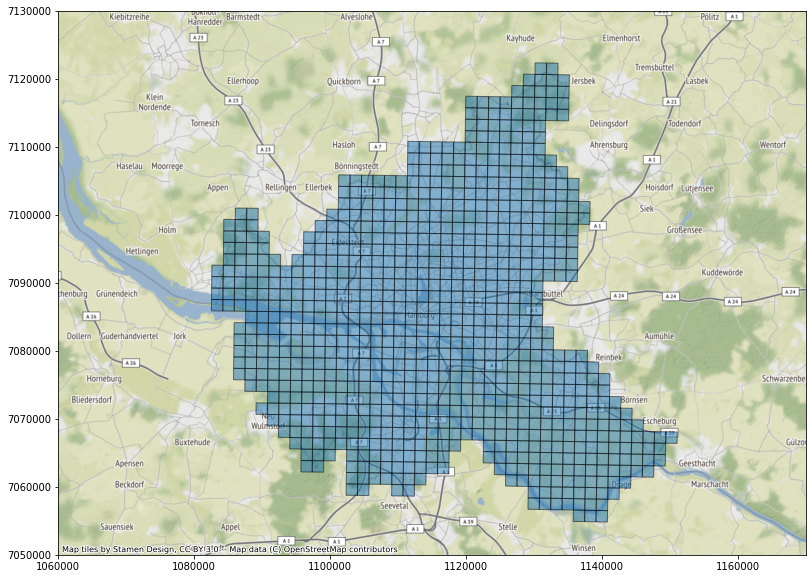

In [12]:
import warnings
import contextily as ctx
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# we assign original CRS
city_grids.crs = {'init' :'epsg:25832'}

# we reproject to match contextility map
city_grids = city_grids.to_crs({'init': 'epsg:3857'})
ax = city_grids.plot(figsize=(15, 10), alpha=0.5, edgecolor='k')

#ctx.add_basemap(ax, url=ctx.providers.Esri.WorldImagery)

ctx.add_basemap(ax)
ax.set_xlim(1060000,1170000)
ax.set_ylim(7050000,7130000)
#ax.set_axis_off()


We can see the grid overlay over Hamburg area. This shows 1km grids of area. They have class names which will be extracted for our data points.

## Housing Data

The housing data will give us average living space per inhabitants in square meters. This is important because some areas can give higher rent yield than others because of higher number of occupants compared to space. I viewed the parameters in this data so to know the exact one to download. This is the one named 'app:wohnstatistik_wohnfl_31122014'.

In [13]:
WfsUrl2 = 'https://geodienste.hamburg.de/HH_WFS_Statistik_Stadtteile_Wohnungsdaten?REQUEST=GetCapabilities&SERVICE=WFS'
stats_data = WebFeatureService(url=WfsUrl2, version='1.1.0')

# We list the contents
print(list(stats_data.contents))

['app:wohnstatistik_wohnfl_31122014', 'app:wohnstatistik_wohngr_31122014', 'app:wohnstatistik_wohn_31122014', 'app:wohnstatistik_wohn_efh_zfh_prz_31122014']


In [14]:
# reading the file from downloaded data
wohnstatistik_wohnfl = gpd.read_file("HH_WFS_Statistik_Stadtteile_Wohnungsdaten.txt")
wohnstatistik_wohnfl.head()

## Note: If this import doesn't work because of some dependent libraries. Please uncomment the codes below use the csv_file
#wohnstatistik_wohnfl = pd.read_csv("wohnstatistik_wohnfl.csv")
#wohnstatistik_wohnfl['geometry'] = wohnstatistik_wohnfl['geometry'].apply(wkt.loads)
#wohnstatistik_wohnfl = gpd.GeoDataFrame(wohnstatistik_wohnfl, geometry = 'geometry')
#wohnstatistik_wohnfl.head()

,gml_id,stadtteil,wohnflaeche_je_einwohner_31.12.2014,geometry
0,APP_WOHNSTATISTIK_WOHNFL_31122014_1,Allermöhe,49.05,"MULTIPOLYGON (((575312.441 5927666.536, 574503..."
1,APP_WOHNSTATISTIK_WOHNFL_31122014_71,Ottensen,38.71,"MULTIPOLYGON (((561452.733 5934918.062, 561502..."
2,APP_WOHNSTATISTIK_WOHNFL_31122014_72,Poppenbüttel,47.77,"MULTIPOLYGON (((572236.855 5947223.822, 572240..."
3,APP_WOHNSTATISTIK_WOHNFL_31122014_73,Rahlstedt,39.75,"MULTIPOLYGON (((576263.118 5936992.093, 576248..."
4,APP_WOHNSTATISTIK_WOHNFL_31122014_2,Alsterdorf,40.84,"MULTIPOLYGON (((568317.759 5940325.328, 568309..."


The column named **wohnflaeche_je_einwohner_31.12.2014** contains the needed variables. These are multipolygons showing the average living space per inhabitant in square meters. I will visualize this in a map to have an idea of the distribution.  

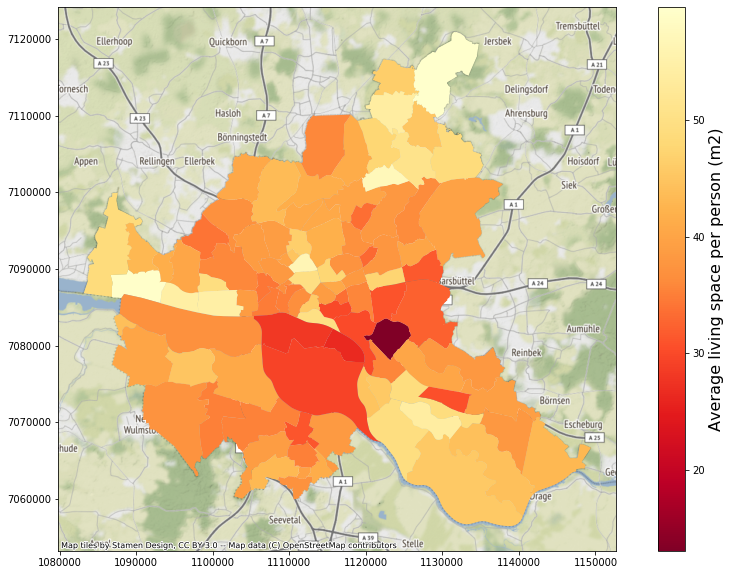

In [15]:
import matplotlib.colors as colors

norm = colors.Normalize(vmin= wohnstatistik_wohnfl["wohnflaeche_je_einwohner_31.12.2014"].min(), vmax=wohnstatistik_wohnfl["wohnflaeche_je_einwohner_31.12.2014"].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd_r')
# we assign original CRS

wohnstatistik_wohnfl.crs = {'init' :'epsg:25832'}

# we reproject to match contextility map
wohnstatistik_wohnfl = wohnstatistik_wohnfl.to_crs({'init': 'epsg:3857'})
# plot
fig, ax = plt.subplots(figsize=(15, 10))
# with no normalization
wohnstatistik_wohnfl.plot(column='wohnflaeche_je_einwohner_31.12.2014', cmap='YlOrRd_r', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Average living space per person (m2)', fontsize = 16)
ctx.add_basemap(ax)

The map shows the distribution. The center part of the city seems to be more concentrated with less than 20 square meters living space for each individual. 

In [16]:
 wohnstatistik_wohnfl.nunique()

gml_id                                 99
stadtteil                              99
wohnflaeche_je_einwohner_31.12.2014    98
geometry                               99
dtype: int64

## Noise Map

We will like to explore areas with high traffic noice. Though this might not have much effect in residential house but may have significant effect in office and business location.

In [17]:
tag_nacht_noise = gpd.read_file("Laermkarten_HH_2018-11-19.gml")
tag_nacht_noise.head()

# Note: If this import doesn't work because of some dependent libraries. Please uncomment the codes below use the csv_file
#tag_nacht_noise = pd.read_csv("tag_nacht_noise.csv")
#tag_nacht_noise['geometry'] = tag_nacht_noise['geometry'].apply(wkt.loads)
#tag_nacht_noise = gpd.GeoDataFrame(tag_nacht_noise, geometry = 'geometry')
#tag_nacht_noise.head()

,gml_id,klasse,geometry
0,APP_STRASSENVERKEHR_TAG_ABEND_NACHT_2017_1,> 55 - 60 dB(A),"POLYGON ((565345.000 5918855.000, 565345.000 5..."
1,APP_STRASSENVERKEHR_TAG_ABEND_NACHT_2017_2,> 55 - 60 dB(A),"POLYGON ((565255.000 5918855.000, 565255.000 5..."
2,APP_STRASSENVERKEHR_TAG_ABEND_NACHT_2017_3,> 55 - 60 dB(A),"POLYGON ((565255.000 5918865.000, 565255.000 5..."
3,APP_STRASSENVERKEHR_TAG_ABEND_NACHT_2017_4,> 55 - 60 dB(A),"POLYGON ((565345.000 5918865.000, 565342.714 5..."
4,APP_STRASSENVERKEHR_TAG_ABEND_NACHT_2017_5,> 55 - 60 dB(A),"POLYGON ((565245.000 5918885.000, 565235.000 5..."


In [18]:
print(tag_nacht_noise.shape)
tag_nacht_noise.nunique()

(78005, 3)


gml_id      78005
klasse          5
geometry    78005
dtype: int64

We can see that we have unique classes for the  noise. lets see these classes

In [19]:
tag_nacht_noise["klasse"].unique()

array(['> 55 - 60 dB(A)', '> 70 - 75 dB(A)', '> 60 - 65 dB(A)',
       '> 65 - 70 dB(A)', '> 75 dB(A)'], dtype=object)

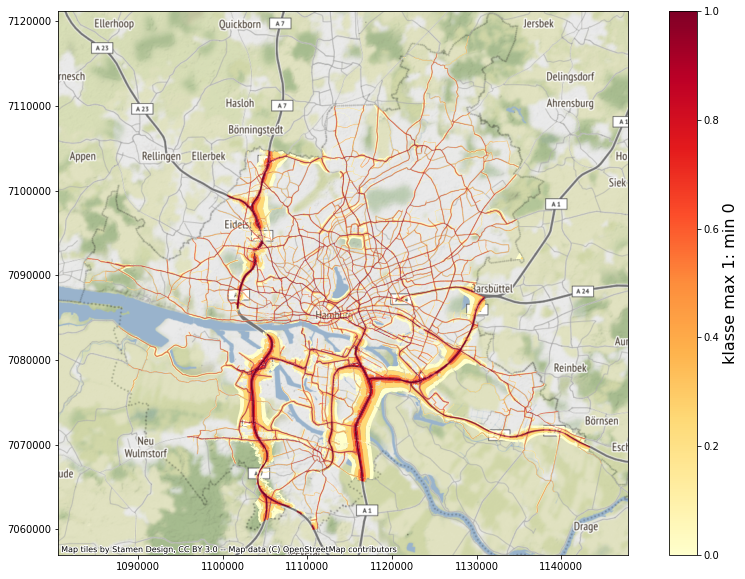

In [20]:
import matplotlib.colors as colors

#norm = colors.Normalize(vmin= tag_nacht_noise["klasse"].min(), vmax=tag_nacht_noise["klasse"].max())
cbar = plt.cm.ScalarMappable(cmap='YlOrRd')
# we assign original CRS

tag_nacht_noise.crs = {'init' :'epsg:25832'}

# we reproject to match contextility map
tag_nacht_noise = tag_nacht_noise.to_crs({'init': 'epsg:3857'})
# plot
fig, ax = plt.subplots(figsize=(15, 10))
# with no normalization
tag_nacht_noise.plot(column='klasse', cmap='YlOrRd', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('klasse max 1: min 0', fontsize = 16)
ctx.add_basemap(ax, zoom = 11)

The high noise areas are represented in red. This is also along major roads. 

# Data Extraction

We will extract the data from these maps and add to the main dataframe and make it ready for Machine Learning algorithm. These data are given with geometry which is the spatial refrence of their locations. We need to create geometry for the main data with the given coordinates.

In [21]:
data1.head()

,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month
0,116.4,4.5,1453.200,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5
1,98.4,3.5,1131.600,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4
2,97.8,3.5,1128.000,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2
3,60.0,2.5,660.000,1964.0,Neugraben-Fischbek,Hamburg,21147,6,13.200,53.479685,9.859130,2019,1
4,78.0,2.5,573.768,1970.0,Marmstorf,Hamburg,21077,7,8.832,53.441503,9.959381,2019,6


I will create a geometry for the data using the WGS84 coordinates

In [22]:
from shapely.geometry import Point, LineString, Polygon

# zipping the coodinates
data1['geometry']  = list(zip(data1['longitude'],data1['latitude']))

#This applies point to the geometry
data1['geometry'] = data1['geometry'].apply(Point)

# converting to geodataframe
data1 = gpd.GeoDataFrame(data1, geometry='geometry')
data1.head()

,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month,geometry
0,116.4,4.5,1453.200,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5,POINT (10.12200 53.59779)
1,98.4,3.5,1131.600,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4,POINT (10.14527 53.62468)
2,97.8,3.5,1128.000,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2,POINT (10.00566 53.65459)
3,60.0,2.5,660.000,1964.0,Neugraben-Fischbek,Hamburg,21147,6,13.200,53.479685,9.859130,2019,1,POINT (9.85913 53.47969)
4,78.0,2.5,573.768,1970.0,Marmstorf,Hamburg,21077,7,8.832,53.441503,9.959381,2019,6,POINT (9.95938 53.44150)


## Projection
We will put all the data in the same projecting WGS84 given by EPGS:4326. For the main dataframe we will just assign projection becasue the coodinates are already in WGS84. For the other dataframes, we will need to reproject into WGS84. Note that we have already assigned their original projections earlier before plotting. 

In [23]:
# assign projection WGS84
data1.crs = {'init' :'epsg:4326'}

# reproject to WGS84
city_grids = city_grids.to_crs({'init' :'epsg:4326'})

#reproject to WGS84
squarem_per_person =  wohnstatistik_wohnfl.to_crs({'init' :'epsg:4326'})

#reproject to WGS84
traffic_noise = tag_nacht_noise.to_crs({'init' :'epsg:4326'})


In [24]:
data1.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
city_grids.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
squarem_per_person.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
traffic_noise.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that we have everything in the same projection, we will define a function that extracts the needed data from the dataframes. This uses polygon intersection as means of extraction. If we want to exclude boundary edges of the polygons, then we use "within" instead of "intersects". But we will include the the boundary edges.

In [28]:
def extract_data(df1,df2, column_name, null_fill):
    """ extract data from df2 and add to df1 based on polygon intersection"""
    """ df1 is the a main data, df2 is the added geodata, column name is the
    target column and null_fill is the value to be used for filling empty cells"""
    
    df1 = re_index(df1)
    df2 = re_index(df2)
    df1[column_name] = " "
    
    for i in range(len(df1)):
        for j in range(len(df2)):
            if df1['geometry'][i].intersects(df2['geometry'][j]):
                df1[column_name][i] = df2[column_name][j]
                
    df1[column_name] = df1[column_name].replace(r'^\s*$', null_fill, regex=True)
    
    return df1
                

## Extraction and Annotation
We apply the functions to extract tiles from the city grids data.

In [29]:
# Applying the function for city grids
data1 = extract_data(data1,city_grids,"kachel",9999)
print(data1[data1["kachel"] == 9999].shape)# checking the filler
print(data1.shape)
data1.head()

(0, 15)
(9332, 15)


,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month,geometry,kachel
0,116.4,4.5,1453.200,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5,POINT (10.12200 53.59779),7439
1,98.4,3.5,1131.600,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4,POINT (10.14527 53.62468),7542
2,97.8,3.5,1128.000,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2,POINT (10.00566 53.65459),6645
3,60.0,2.5,660.000,1964.0,Neugraben-Fischbek,Hamburg,21147,6,13.200,53.479685,9.859130,2019,1,POINT (9.85913 53.47969),5725
4,78.0,2.5,573.768,1970.0,Marmstorf,Hamburg,21077,7,8.832,53.441503,9.959381,2019,6,POINT (9.95938 53.44150),6321


We apply the function for the average square meters per individual data.

In [30]:
# Applying the function for squarem_per_person
data1 = extract_data(data1,squarem_per_person,"wohnflaeche_je_einwohner_31.12.2014",0)
print(data1[data1["wohnflaeche_je_einwohner_31.12.2014"] == 0].shape) # checking the filler
print(data1.shape)
data1.head()

(0, 16)
(9332, 16)


,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month,geometry,kachel,wohnflaeche_je_einwohner_31.12.2014
0,116.4,4.5,1453.200,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5,POINT (10.12200 53.59779),7439,36.27
1,98.4,3.5,1131.600,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4,POINT (10.14527 53.62468),7542,39.75
2,97.8,3.5,1128.000,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2,POINT (10.00566 53.65459),6645,35.94
3,60.0,2.5,660.000,1964.0,Neugraben-Fischbek,Hamburg,21147,6,13.200,53.479685,9.859130,2019,1,POINT (9.85913 53.47969),5725,37.42
4,78.0,2.5,573.768,1970.0,Marmstorf,Hamburg,21077,7,8.832,53.441503,9.959381,2019,6,POINT (9.95938 53.44150),6321,43.13


We can rename the adopted columns to be more understandable

In [31]:
data1 = data1.rename(columns={"kachel": "1km_tile", "wohnflaeche_je_einwohner_31.12.2014": "square_m_per_person"}, errors="raise")
data1.head(3)

,living_space,rooms,cold_rent,construction_year,quarter,city,postcode,heating_type,rent_per_square_meter,latitude,longitude,publish_year,publish_month,geometry,1km_tile,square_m_per_person
0,116.4,4.5,1453.2,1976.0,Farmsen-Berne,Hamburg,22159,6,14.976,53.597793,10.121997,2019,5,POINT (10.12200 53.59779),7439,36.27
1,98.4,3.5,1131.6,1982.0,Rahlstedt,Hamburg,22145,1,13.800,53.624685,10.145269,2019,4,POINT (10.14527 53.62468),7542,39.75
2,97.8,3.5,1128.0,2021.0,Langenhorn,Hamburg,22419,5,13.836,53.654590,10.005658,2019,2,POINT (10.00566 53.65459),6645,35.94


We explore the classes in traffic_noise.

In [32]:
traffic_noise["klasse"].unique()

array(['> 55 - 60 dB(A)', '> 70 - 75 dB(A)', '> 60 - 65 dB(A)',
       '> 65 - 70 dB(A)', '> 75 dB(A)'], dtype=object)

Well it is just 5 classes in the Noise data which may not contribute much to our model. So i will drop it. But if in any case, we are interested in using it, we will add a class for where the noise level is less than 55, because alot of our coordinates will definitely fall outside the noise area. We will name this class '< 55  dB(A)'. This will be our filler. Note that it will also take some time because it is up to 70,000 data points. 

One more thing we may do before developing the model is to plot our target variable  **"rent_per_square_meter"** and see the spatial distribution on the  map. Now that I have created polygon for data1, I can visualize all of its attributes on a spatial scale (Map). So I am Interested in seeing the distribution of the target variable for the model.

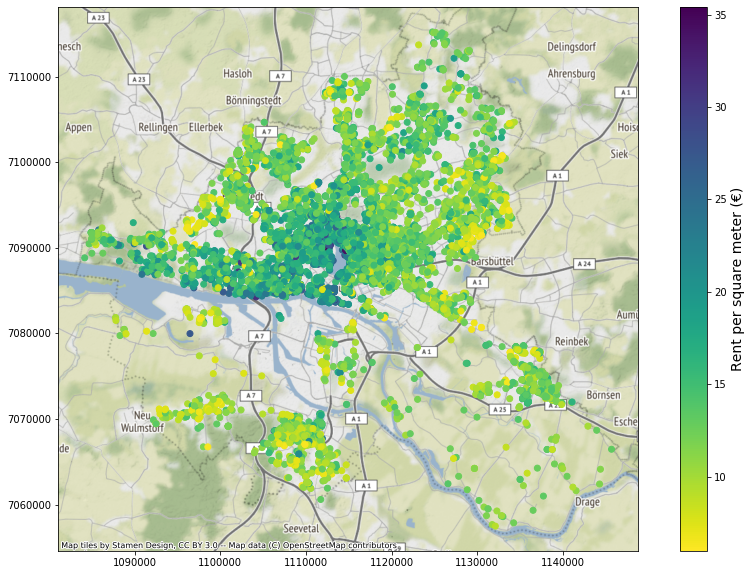

In [33]:
# we reproject to match contextility map
rent_plot = data1.to_crs({'init': 'epsg:3857'})

norm = colors.Normalize(vmin= rent_plot["rent_per_square_meter"].min(), vmax=rent_plot["rent_per_square_meter"].max())

cbar = plt.cm.ScalarMappable(cmap='viridis_r', norm = norm)

# plot
fig, ax = plt.subplots(figsize=(15, 10))
# with no normalization
rent_plot.plot(column='rent_per_square_meter', cmap='viridis_r', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Rent per square meter (€)', fontsize = 14)
ctx.add_basemap(ax, zoom = 11)

We can see that there are a few clusters of certain price range in the data. We have higher rent per square meters towards the center of the city. It also increases closer to the waterfront. This could be explored futher. Every variable on the data can be visualized. The average rent per square meter for each tile (1km, 2km, 5km or any size we choose) can also be obtained and used for prediction. For instance we can divide the map into sections, obtain the average rent per square meter for each tile every year and plot the time series to see the trends and progression. This can be used to forecast what the rent per square meter of a house in an area will be in future. For the purpose of this excercise, I will build the model with the current variables. 

# Machine Learning Model

The aim is to produce a Machine learnig model, enhanced with Geo-data. So I will build a Multilayer Perceptron (MLP) with Keras for this regression excercise.

In [35]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder

Now we will drop the unnecessary columns and split the data into train and test. Since we have extracted the location related attributes, we can drop the longitude, latitude and geometry. We split the data into training and test sets.

In [36]:
# drop columns
df = data1.drop(["latitude", "longitude", "geometry",], axis = 1)

# split data
train, test = train_test_split(df, test_size=0.30, random_state=42)

I will perfom some feature engineering to prepare the data for the Machine learning model.

In [37]:
def process_dataframe(df, train, test):
    
    """ processing the training and test X data"""
    # initialize the column names of the continuous data
    continuous = ["living_space", "rooms", "cold_rent", "construction_year", "publish_year", "publish_month", "square_m_per_person"]
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    
    # one-hot encode the categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    # Using LabelBinarizer for all categorical variables
    tileBinarizer = LabelBinarizer().fit(df["1km_tile"])
    traintile = tileBinarizer.transform(train["1km_tile"])
    testtile = tileBinarizer.transform(test["1km_tile"])
    
    zipBinarizer = LabelBinarizer().fit(df["postcode"])
    trainzip = zipBinarizer.transform(train["postcode"])
    testzip = zipBinarizer.transform(test["postcode"])
                                     
    heatBinarizer = LabelBinarizer().fit(df["postcode"])
    trainheat = heatBinarizer.transform(train["postcode"])
    testheat = heatBinarizer.transform(test["postcode"]) 
                                       
    
    quatBinarizer = LabelBinarizer().fit(df["quarter"])
    trainquaters = quatBinarizer.transform(train["quarter"])
    testquaters = quatBinarizer.transform(test["quarter"])
    
    cityBinarizer = LabelBinarizer().fit(df["city"])
    traincity = cityBinarizer.transform(train["city"])
    testcity = cityBinarizer.transform(test["city"]) 
                                      
    trainX = np.hstack([traintile,trainzip,trainheat,trainquaters,traincity, trainContinuous])
    testX = np.hstack([testtile, testzip,testheat,testquaters,testcity, testContinuous])
    
                                      
    return trainX, testX
    

Now I apply the function to obtain the train and test sets. I also do some scaling to enhance learning on the y data

In [38]:
trainX, testX = process_dataframe(df, train, test)
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] for better training and convergence)

maxPrice = train["rent_per_square_meter"].max()
trainY = train["rent_per_square_meter"] / maxPrice
testY = test["rent_per_square_meter"] / maxPrice

I will create the MPL model with the dimension and the regression options as imput (it could also be used for classification). Adam optimizer will be used and the mean absolute percentage error will be the measured loss.

In [39]:
def create_mdl(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

model = create_mdl(trainX.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 100)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

Here we fit the model and let it run for 100 epochs with batch size 8.

In [40]:
#training the model
history = model.fit(x=trainX, y=trainY, validation_data=(testX, testY), epochs=100, batch_size=8)

Epoch 1/100
817/817 [==============================] - 1s 1ms/step - loss: 22.1124 - val_loss: 15.2482
Epoch 2/100
817/817 [==============================] - 1s 1ms/step - loss: 14.3314 - val_loss: 14.1615
Epoch 3/100
817/817 [==============================] - 1s 1ms/step - loss: 12.9836 - val_loss: 13.2259
Epoch 4/100
817/817 [==============================] - 1s 1ms/step - loss: 11.9481 - val_loss: 12.2803
Epoch 5/100
817/817 [==============================] - 1s 1ms/step - loss: 11.1257 - val_loss: 12.0017
Epoch 6/100
817/817 [==============================] - 1s 1ms/step - loss: 10.5640 - val_loss: 10.9266
Epoch 7/100
817/817 [==============================] - 1s 1ms/step - loss: 9.8124 - val_loss: 10.5389
Epoch 8/100
817/817 [==============================] - 1s 1ms/step - loss: 9.3529 - val_loss: 9.9863
Epoch 9/100
817/817 [==============================] - 1s 1ms/step - loss: 8.7782 - val_loss: 9.6077
Epoch 10/100
817/817 [==============================] - 1s 1ms/step - loss: 8.

In [41]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


The model seems to have performed well stopping at val_loss of 3.7%. I will  visualize this in a plot.

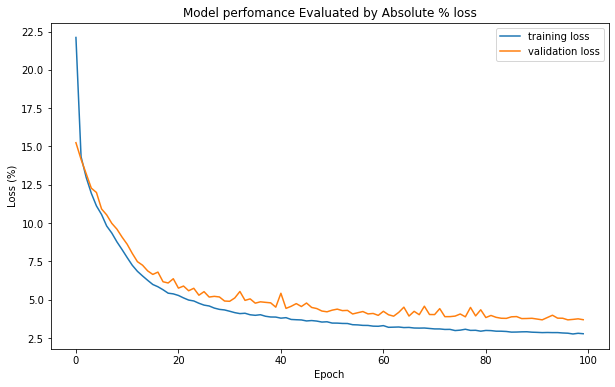

In [42]:
# "Loss Plot 
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model perfomance Evaluated by Absolute % loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

Now I will predict on testX and obtain the mean absolute percentage difference.

In [43]:
preds = model.predict(testX)
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100

absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
import locale
locale.setlocale(locale.LC_ALL, "de_DE.UTF-8")
print("avg. rent per square meter: {}  std house price: {}".format(
    locale.currency(df["rent_per_square_meter"].mean(), grouping=True),
    locale.currency(df["rent_per_square_meter"].std(), grouping=True)))
print("mean absolute percentage loss: {: .2f}%, std: {: .2f}%".format(mean, std))

avg. rent per square meter: Eu14,59  std house price: Eu4,31
mean absolute percentage loss:  3.70%, std:  4.27%


In [44]:
# serialize model to JSON
model_json = model.to_json()
with open("Geo_data_MPL_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Geo_data_MPL_model.h5")

## load json and create model

#json_file = open('Geo_data_MPL_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

## load weights into new model
#loaded_model.load_weights("Geo_data_MPL_model.h5")

# SUMMARY

The model performed well with the addition of Geo-data. More environmental variables can also be explored for future predictions. Waterfronts could also be a good area to explore. There may be relationships with prices there. This can be done by applying a buffer around the waterfront polygons. Houses that fall into this buffer can be extracted and evaluated. Geospatial analysis can also be done to visualize all vatriables in the data on a spatial scale. This will help in identifying and narrowing interest areas.

# Reference

Condo Group GmbH 

Hamburg Geoportal